In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as snc

import netCDF4 as nc
# from netCDF4 import Dataset 
plt.style.use('classic')
import warnings

# added later
from sklearn.preprocessing import StandardScaler
from datasketch import MinHash, MinHashLSH
from scipy.stats import pearsonr

In [2]:
modis_ds = nc.Dataset('/Volumes/Aqua-1/SST_OOD/MODIS_L2/PreProc/MODIS_R2019_2003_95clear_128x128_preproc_std.h5')
modis_ds_valid = modis_ds['valid'][:100000, 0, :, :]


Feature Extraction:

In [3]:
# Step 1: Flatten the 64x64 regions
flattened_features = modis_ds_valid.reshape(modis_ds_valid.shape[0], -1)  # Reshapes to (700000, 4096)
# Step 2: Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(flattened_features)

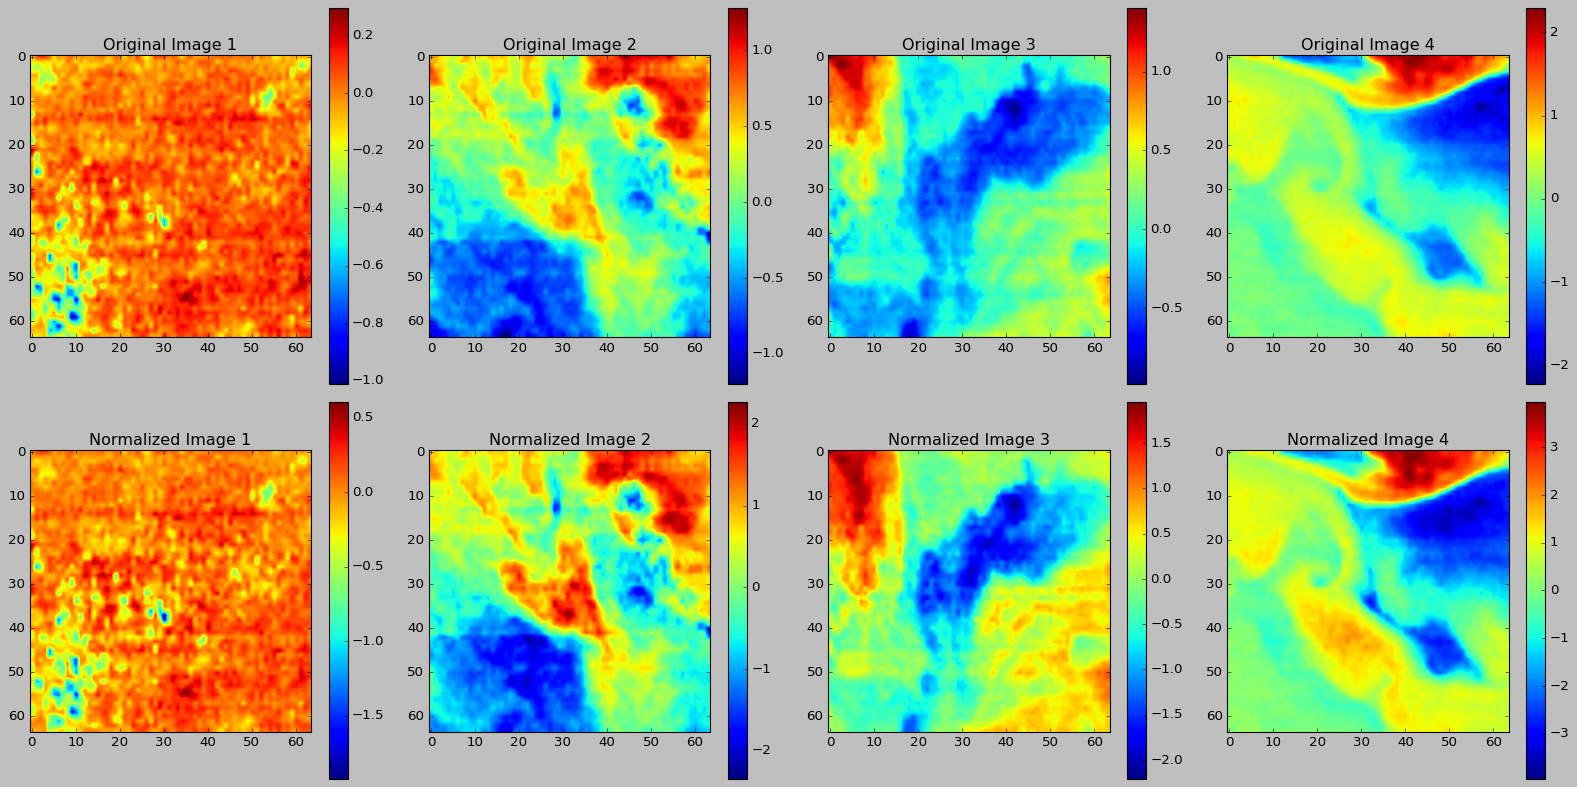

In [4]:
# Simulating a smaller version of the dataset for demonstration
np.random.seed(0)

# Selecting 4 random images from the dataset
np.random.seed(0)
indices = np.random.choice(modis_ds_valid.shape[0], 4, replace=False)
selected_images = modis_ds_valid[indices]

# Normalizing the data
scaler = StandardScaler()
normalized_features_mock = scaler.fit_transform(modis_ds_valid.reshape(-1, 64*64)).reshape(-1, 64, 64)
selected_normalized_images = normalized_features_mock[indices]

# Plotting the original and normalized images
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i in range(4):
    # Original image
    im = axes[0, i].imshow(selected_images[i])
    axes[0, i].set_title(f"Original Image {i+1}")
    fig.colorbar(im, ax=axes[0, i])  # Add colorbar for each original image


    # Normalized image
    im_norm = axes[1, i].imshow(selected_normalized_images[i])
    axes[1, i].set_title(f"Normalized Image {i+1}")
    fig.colorbar(im_norm, ax=axes[1, i])  # Add colorbar for each normalized image


plt.tight_layout()
plt.show()



In [7]:


def flatten_and_normalize_data(data):
    # Flatten the data
    flattened_data = data.reshape(data.shape[0], -1)
    # Normalize the data
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(flattened_data)
    return normalized_data

def quantize_data(data, bins=100):
    # Quantize data to reduce the granularity
    quantized_data = np.digitize(data, bins=np.linspace(data.min(), data.max(), bins))
    return quantized_data.astype(np.int64)

def create_lsh_index(data, num_perm=128):
    lsh = MinHashLSH(threshold=0.5, num_perm=num_perm)
    minhashes = {}
    for i, vec in enumerate(data):
        minhash = MinHash(num_perm=num_perm)
        for d in vec:
            minhash.update(str(d).encode('utf8'))
        lsh.insert(i, minhash)
        minhashes[i] = minhash
    return lsh, minhashes

def find_top_similar_images(lsh, minhashes, reference_idx, top_n=100):
    result = lsh.query(minhashes[reference_idx])
    # Sort results by similarity and return top_n
    sorted_result = sorted(result, key=lambda idx: minhashes[reference_idx].jaccard(minhashes[idx]), reverse=True)
    return sorted_result[:top_n]


data = modis_ds_valid
normalized_data = flatten_and_normalize_data(data)
quantized_data = quantize_data(normalized_data)
lsh, minhashes = create_lsh_index(quantized_data)

reference_idx = 0  # Index of the reference image, can be any valid index
top_similar_indices = find_top_similar_images(lsh, minhashes, reference_idx, top_n=100)

# top_similar_indices contains the indices of the top 100 similar images
print(top_similar_indices)


[0, 99, 200, 202, 215, 217, 230, 264, 288, 343, 372, 522, 527, 565, 600, 778, 781, 813, 816, 842, 878, 940, 944, 945, 976, 987, 1040, 1061, 1072, 1156, 1200, 1203, 1383, 1422, 1428, 1467, 1582, 1603, 1622, 1639, 1649, 1652, 1662, 1676, 1713, 1715, 1772, 1775, 1828, 1873, 1885, 1927, 1935, 1957, 1975, 2002, 2038, 2085, 2195, 2202, 2257, 2490, 2536, 2548, 2588, 2686, 2881, 2882, 2907, 2918, 2960, 3088, 3104, 3212, 3220, 3221, 3229, 3334, 3359, 3366, 3424, 3472, 3510, 3540, 3545, 3595, 3602, 3653, 3655, 3678, 3778, 3802, 3823, 4010, 4035, 4041, 4044, 4094, 4098, 4129]


In [9]:
def calculate_correlation(image1, image2):
    return pearsonr(image1.flatten(), image2.flatten())[0]

def calculate_mse(image1, image2):
    return ((image1 - image2) ** 2).mean()

def calculate_histogram_intersection(image1, image2):
    hist1, _ = np.histogram(image1, bins=256, range=(0, 256))
    hist2, _ = np.histogram(image2, bins=256, range=(0, 256))
    return np.sum(np.minimum(hist1, hist2)) / np.sum(hist2)


import numpy as np
from scipy.stats import pearsonr

def evaluate_similarity(data, indices):
    reference_image = data[0]
    correlations, mses, hist_intersections = [], [], []
    
    for idx in indices:
        image = data[idx]
        correlation = pearsonr(reference_image.flatten(), image.flatten())[0]
        mse = ((reference_image - image) ** 2).mean()
        hist_intersection = calculate_histogram_intersection(reference_image, image)

        correlations.append(correlation)
        mses.append(mse)
        hist_intersections.append(hist_intersection)
    
    return np.mean(correlations), np.mean(mses), np.mean(hist_intersections)

# Hyperparameter tuning
num_perms = [128, 256]
thresholds = [0.0, 0.25, 0.50, 0.75, 1.0]
best_config = {}
best_score = -np.inf

for num_perm in num_perms:
    for threshold in thresholds:
        lsh, minhashes = create_lsh_index(quantized_data, num_perm=num_perm)
        top_similar_indices = find_top_similar_images(lsh, minhashes, reference_idx=0, top_n=100)
        
        correlation, mse, hist_intersection = evaluate_similarity(normalized_data, top_similar_indices)
        score = correlation - mse + hist_intersection  # Example scoring function

        if score > best_score:
            best_score = score
            best_config = {'num_perm': num_perm, 'threshold': threshold, 'correlation': correlation, 'mse': mse, 'hist_intersection': hist_intersection}

print(f"Best configuration: {best_config}")


reference_image = data[reference_idx]

# Calculate similarity metrics for the top similar images
for idx in top_similar_indices:
    image = data[idx]
    correlation = calculate_correlation(reference_image, image)
    mse = calculate_mse(reference_image, image)
    hist_intersection = calculate_histogram_intersection(reference_image, image)

    print(f"Image {idx} - Correlation: {correlation}, MSE: {mse}, Histogram Intersection: {hist_intersection}")


Best configuration: {'num_perm': 128, 'threshold': 0.0, 'correlation': -0.00371091482129422, 'mse': 0.36396545, 'hist_intersection': 0.9994484066885039}
Image 0 - Correlation: 1.0, MSE: 0.0, Histogram Intersection: 1.0
Image 99 - Correlation: 0.10955389417869463, MSE: 0.0959089919924736, Histogram Intersection: 1.0
Image 200 - Correlation: 0.017760105856297573, MSE: 0.08616771548986435, Histogram Intersection: 1.0
Image 202 - Correlation: -0.3701026929184563, MSE: 0.09753277897834778, Histogram Intersection: 1.0
Image 215 - Correlation: -0.30806709691985135, MSE: 0.10815349966287613, Histogram Intersection: 1.0
Image 217 - Correlation: -0.1433036872536659, MSE: 0.10833589732646942, Histogram Intersection: 1.0
Image 230 - Correlation: -0.26154611143088236, MSE: 0.14734871685504913, Histogram Intersection: 1.0
Image 264 - Correlation: 0.03155172968124795, MSE: 0.0808228999376297, Histogram Intersection: 1.0
Image 288 - Correlation: -0.348793779531852, MSE: 0.0976429432630539, Histogram I

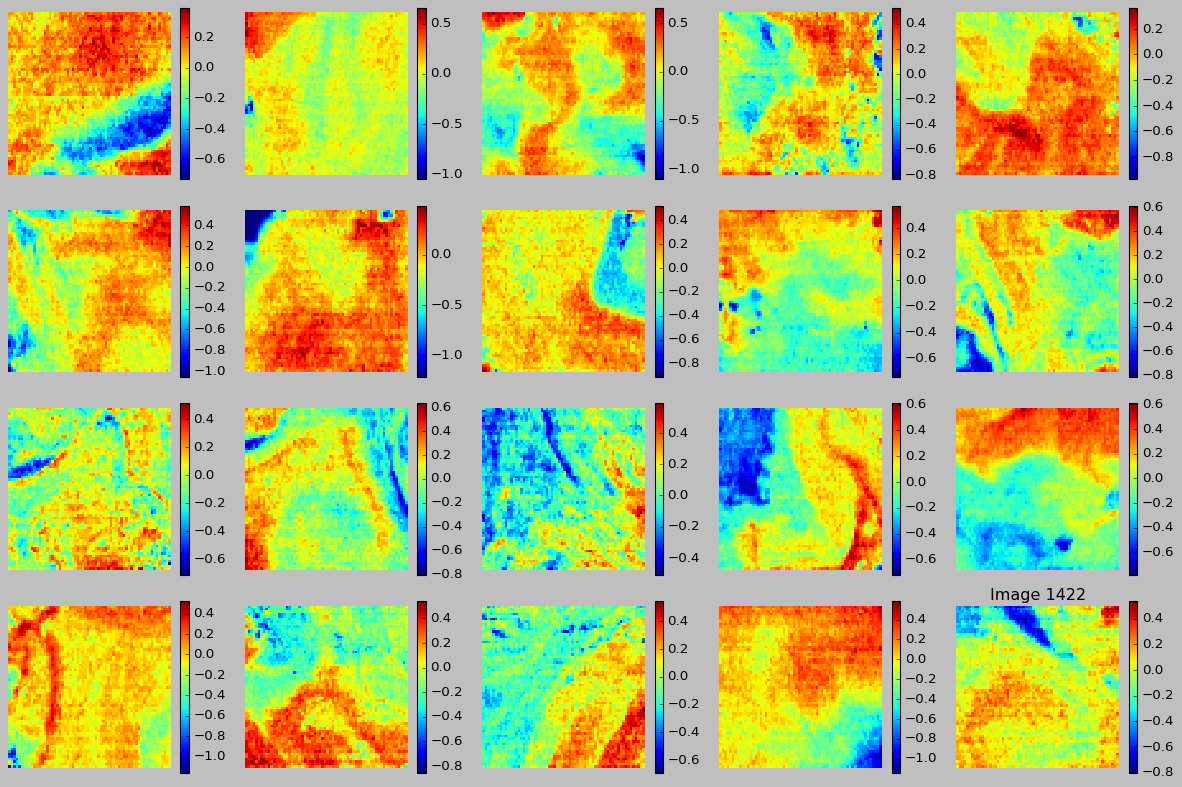

In [12]:


def plot_images(data, indices, rows=4, cols=5, figsize=(15, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(indices):
            im  = ax.imshow(data[indices[i]], interpolation='nearest')
            ax.axis('off')
            plt.colorbar(im, ax=ax)
            plt.title(f"Image {indices[i]}")
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

data = modis_ds_valid[:10000, :, :]
normalized_data = flatten_and_normalize_data(data)
quantized_data = quantize_data(normalized_data)
lsh, minhashes = create_lsh_index(quantized_data)

reference_idx = 0  # Index of the reference image, can be any valid index
top_similar_indices = find_top_similar_images(lsh, minhashes, reference_idx, top_n=20)

# Plot the top 100 similar images
plot_images(data, top_similar_indices)


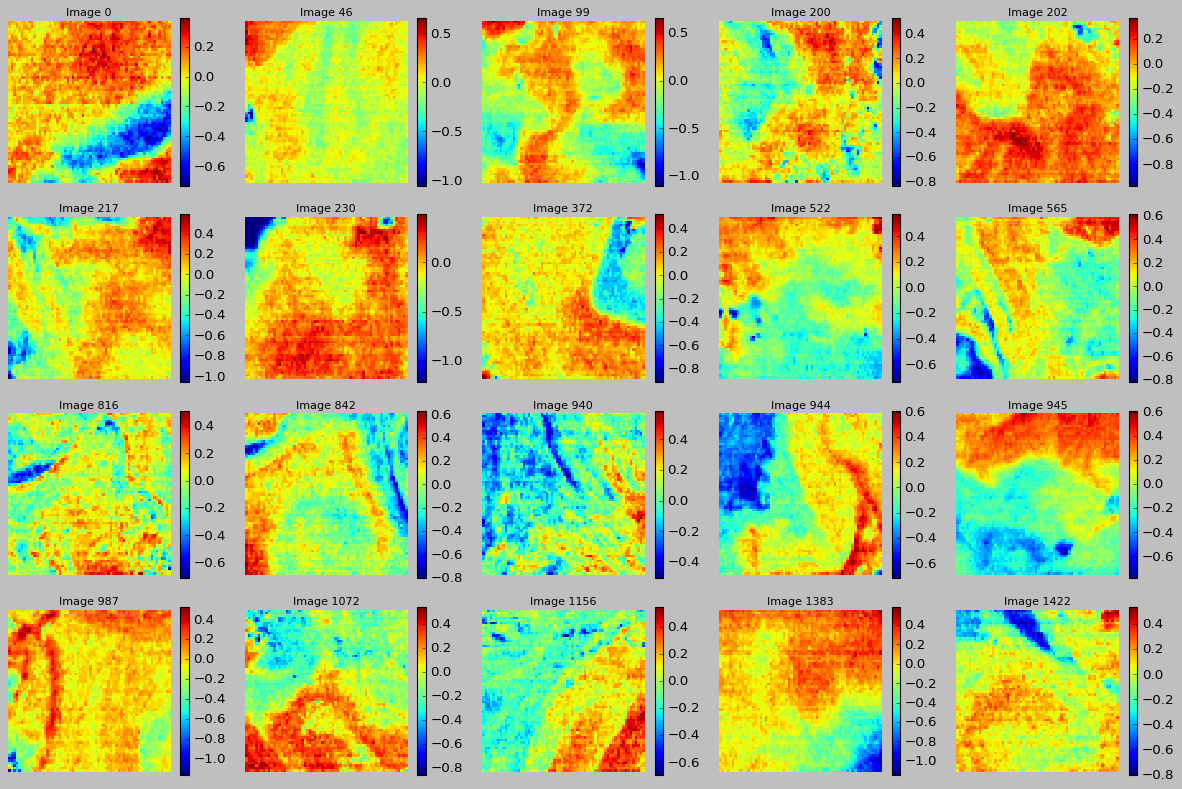

In [13]:
def plot_images(data, indices, rows=4, cols=5, figsize=(15, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(indices):
            im = ax.imshow(data[indices[i]], interpolation='nearest')
            ax.set_title(f"Image {indices[i]}", fontsize=10)  # Set title to the index of the image
            ax.axis('off')
            plt.colorbar(im, ax=ax)
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

data = modis_ds_valid[:10000, :, :]  # Replace with your SST data
normalized_data = flatten_and_normalize_data(data)
quantized_data = quantize_data(normalized_data)
lsh, minhashes = create_lsh_index(quantized_data)

reference_idx = 0  # Index of the reference image, can be any valid index
top_similar_indices = find_top_similar_images(lsh, minhashes, reference_idx, top_n=20)

# Plot the top 20 similar images with indices
plot_images(data, top_similar_indices)


In [14]:
def calculate_image_statistics(image):
    min_temp = np.min(image)
    max_temp = np.max(image)
    avg_temp = np.mean(image)
    return min_temp, max_temp, avg_temp

statistics = []

for idx in top_similar_indices:
    image = data[idx]
    min_temp, max_temp, avg_temp = calculate_image_statistics(image)
    correlation = calculate_correlation(data[reference_idx], image)
    mse = calculate_mse(data[reference_idx], image)
    hist_intersection = calculate_histogram_intersection(data[reference_idx], image)
    statistics.append((idx, min_temp, max_temp, avg_temp, correlation, mse, hist_intersection))

# Now, 'statistics' contains all the required data for each image


In [15]:
statistics

[(0, -0.7294769, 0.39302254, -5.438924e-07, 1.0, 0.0, 1.0),
 (46,
  -1.0519943,
  0.6588707,
  8.2701445e-07,
  0.04546150285707299,
  0.06517751,
  1.0),
 (99,
  -1.1001034,
  0.656147,
  7.4133277e-07,
  0.10955389417869463,
  0.09590899,
  1.0),
 (200,
  -0.8321934,
  0.52555656,
  -7.9954043e-07,
  0.017760105856297573,
  0.086167715,
  1.0),
 (202,
  -0.9709835,
  0.3639269,
  -8.158386e-07,
  -0.3701026929184563,
  0.09753278,
  1.0),
 (217,
  -1.0560284,
  0.5889721,
  -3.5390258e-08,
  -0.1433036872536659,
  0.1083359,
  1.0),
 (230,
  -1.2120857,
  0.4854126,
  -1.3150275e-06,
  -0.26154611143088236,
  0.14734872,
  1.0),
 (372,
  -0.9128189,
  0.52149963,
  -2.4586916e-07,
  -0.15347833861228422,
  0.09858393,
  1.0),
 (522,
  -0.7386532,
  0.5720444,
  5.1036477e-07,
  0.24850263159681552,
  0.06069099,
  1.0),
 (565,
  -0.8163166,
  0.6124325,
  -3.3900142e-07,
  0.2185781478817766,
  0.07142354,
  1.0),
 (816,
  -0.71125793,
  0.51046944,
  -1.5832484e-07,
  -0.21226042224